# Material Balances XI

This lecture introduces Levenspiel Plots to compare sizing trends for a single CSTR and PFR for various reaction orders.

In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quadrature
from math import ceil, floor

## Levenspiel Plots

We're going to take a small break from the usual problem solutions and consider a graphical approach to reactor sizing. It is a pretty old method, but I think it helps to build some useful insight about how reactor size (or time required inside of the reactor) scale with the reaction rate.  It also helps us to visualize the differences between PFR and CSTR reactor sizes required to achieve the exact same conversion level for a given reaction.

We will also use these to help to visualize optimal strategies for reactor sequencing when our process involves more than one reactor (and sometimes more than one type of reactor).

To begin, we will write material balances on a CSTR and a PFR.  We'll only use this approach for these two reactors, but the concepts are fairly general.

We'll consider a simple, irreversible reaction:

$$A \longrightarrow B$$

We'll assume that its rate only depends on the concentration of species A and that the density of the fluid in the reactor is constant.  We will not specify a rate law yet as we want to look at some general concepts abour reactor sizing first.

### A generic CSTR Balance

If we write a balance on species A for a CSTR operating at steady state, we get:

$$0 = F_{A,f} - F_A + R_AV$$

We really want to consider the size of the reactor in this analysis, so we'll solve this balance for Volume:

$$V = \frac{-(F_{A,f} - F_A)}{R_A}$$

For this simple reaction, we know that:

$$R_A = -r$$

We have to recognize that the rate of reaction will *generally* depend on the fractional conversion of reactant, so I'm actually going to write this to show that functional dependence explicitly:

$$R_A = -r \, (X_A)$$

We also can derive the following result from the definition of fractional conversion of A in a flow reactor:

$$F_{A,f} - F_A = F_{A,f}X_A$$

Substituting those two results into the expression for Volume, we find:

$$V = \frac{F_{A,f}X_A}{r \, (X_A)}$$

The numerator of that expression conceptually represents the extensive rate at which species A is consumed in the reactor.  The denominator represents the intensive rate of reaction (per unit volume). If we divde the quantity of species being consumed per time by the rate at which they are consumed per unit volume, we get the size of the system.

### A Generic PFR Balance

We start by writing the usual PFR balance on A:

$$\frac{dF_A}{dV} = R_A$$

We express the Flowrate of A as a function of conversion:

$$F_A = F_{A,f} - F_{A,f}X_A = F_{A,f} (1 - X_A)$$

And we know from the CSTR balance above that:

$$R_A = -r \, (X_A)$$

Where, again, the $r \, (X_A)$ term indicates explicitly that rate is a function of fractional conversion of A.  Making these substitutions into the material balance, we get

$$\frac{dX_A}{dV} = \frac{r \, (X_A)}{F_{A,f}}$$

I'm going to rearrange that.

$$dV = \frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

**Note**: That is actually a differential analog of the CSTR balance.  See below.

$$V_\textrm{CSTR} = \frac{F_{A,f}X_A}{r \, (X_A)}$$

The PFR is basically the differential version of this.  The differential change in volume (dV) is equal to the differential quantity of species A that convert in the reactor divided by the intensive rate at which it is converted.  If we want to solve for the total PFR volume to compare to the total CSTR volume, we have to integrate the PFR balance above:

$$\int_0^{V_\textrm{PFR}}dV = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

The left hand side is easy to integrate, and we get the result that:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

Again, loosely, the size of the PFR depends on the quantity of species that we are converting divided by the rate at which we convert them.

### General Ideas

What we see from these equations is that the size of the reactor (whether it is a PFR or a CSTR) scales directly with the quantity of "stuff" converted in that reactor, and it scales inversely with the rate of reaction.  

In other words, the more "stuff" the reactor needs to convert, the larger it needs to be (everything else fixed). Analogously, the faster the reaction occurs (larger r), the smaller the reactor needs to be.  So those are the general things we need to think about when we consider reactor sizes and especially when we compare the performance of CSTRs and PFRs: how much extensive conversion does the reactor need to accomplish, and how quickly does the reaction occur inside of that reactor.

The differences between CSTRs and PFRs will depend on the reaction rate, specificially how the reaction rate changes as a function of fractional conversion.  Until we know that relationship, we can't really compare the sizes of these two reactors.

### A general rate of reaction

For this simple reaction:

$$A \longrightarrow B$$

We can propose that the rate of reaction scales with the concentration of A in some power law relationship.  Something like:

$$r = k{C_A}^\alpha$$

Where $\alpha$ is an unspecified reaction order (0, 1, -3, 0.5, etc.).  We know that we can express the concentration of A as a function of fractional conversion of A:

$$C_A = \frac{F_A}{Q}$$

For a constant density flow reactor (we have made this assumption already):

$$C_A = \frac{F_A}{Q_f}$$

And we can express the molar flowrate as a function of conversion:

$$C_A = \frac{F_{A,f}(1 - X_A)}{Q_f}$$

We can see that this simplifies to the following (for a constant density flow reactor):

$$C_A = C_{A,f} \, (1 - X_A)$$

We can substitute that into our rate expression:

$$r = k{C_{A,f}}^\alpha \, (1 - X_A)^\alpha$$

Now with a power law expression, we can consider how rate of reaction changes as a function of fractional conversion.  This really depends on the value of $\alpha$, specifically, whether it is less than, greater than, or equal to zero.

Let's consider these cases for numerical values of k = 1 and $C_{A,f} = 1$.  The rate constant will always have correct units so that we get the reaction rate in dimensions of moles per volume per time.

What we'll do next is include this generic rate expression into our generic PFR and CSTR balances.  Then we'll compare PFR and CSTR sizes as a function of fractional conversion, and see how trends change when we vary the reaction order ($\alpha$).  

### A general solution for CSTR volume

Recall, our CSTR Balance is given by:

$$V_\textrm{CSTR} = \frac{F_{A,f}X_A}{r \, (X_A)}$$

So, I'll just write a function that calculates the CSTR Volume for any value of fractional conversion and alpha. Just for illustration of how to use this, we'll calculate the CSTR volume required to achieve a conversion of 50% for a first order reaction (1 Liter).

In [2]:
def VCSTR(XA, alpha):
    FAf = 1 #mol/min
    Qf  = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    CA  = CAf*(1 - XA)
    r   = k*CA**alpha
    V   = FAf*XA/r
    return V
print(VCSTR(0.5, 1))

1.0


### A general solution for PFR volume

Next, we recall the solution for PFR volume:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

We can replace the rate law with the generic function of XA and alpha as above.  We also need to integrate this equation to solve for the PFR volume, but this is straightforward with Gaussian Quadrature. See below; we'll write this as a general function that takes the desired conversion and reaction order as arguments and then solves the corresponding definite integral to find the PFR Volume

In [3]:
def VPFR(XA, alpha):
    FAf = 1 #mol/min
    Qf  = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    CA  = lambda X: CAf*(1 - X)
    r   = lambda X: k*CA(X)**alpha
    
    intfun   = lambda X: FAf/r(X)
    vol, err = quadrature(intfun, 0, XA)
    return vol
print(VPFR(0.5, 1))

0.6931471805400136


### A comparison of CSTR and PFR Volumes for a first order reaction

Now that we have those general functions set up, we will compare results for a few different reaction orders. There are a handful of ways we can do this.  For the CSTR, I'll just pass a numpy array of desired conversions into the VCSTR function.  For the PFR, I'll have to use a loop since quadrature won't take an array as an argument (upper limit of integration).  I'll use a list comprehension for this, which is basically a shorthand for loop.

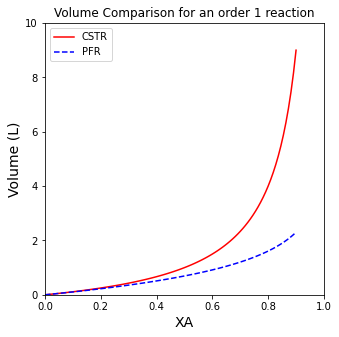

In [4]:
order = 1
XAset = np.linspace(0, 0.9, 100)
VCSTRset = VCSTR(XAset, order)
templist = [VPFR(val, order) for val in XAset] 
VPFRset  = np.array(templist)
#Create and format figure
plt.figure(1, figsize = (5,5))
plt.plot(XAset, VCSTRset, color = 'red', label = 'CSTR')
plt.plot(XAset, VPFRset,  color = 'blue', label = 'PFR', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 10)
plt.title(f'Volume Comparison for an order {order} reaction')
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend()
plt.show()

### A comparison of CSTR and PFR Volumes for a zero order reaction

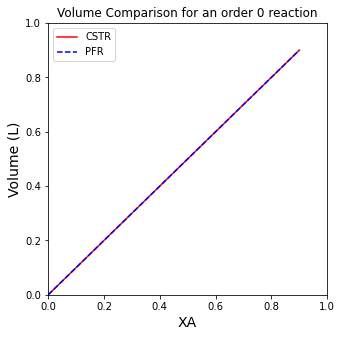

In [5]:
order = 0
XAset = np.linspace(0, 0.9, 100)
VCSTRset = VCSTR(XAset, order)
templist = [VPFR(val, order) for val in XAset] 
VPFRset  = np.array(templist)
#Create and format figure
plt.figure(1, figsize = (5,5))
plt.plot(XAset, VCSTRset, color = 'red', label = 'CSTR')
plt.plot(XAset, VPFRset,  color = 'blue', label = 'PFR', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title(f'Volume Comparison for an order {order} reaction')
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend()
plt.show()

### A comparison of CSTR and PFR Volumes for a -1 order reaction

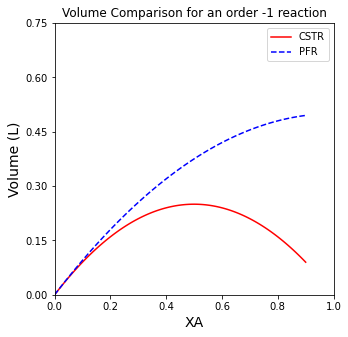

In [6]:
order = -1
XAset = np.linspace(0, 0.9, 100)
VCSTRset = VCSTR(XAset, order)
templist = [VPFR(val, order) for val in XAset] 
VPFRset  = np.array(templist)
#Create and format figure
plt.figure(1, figsize = (5,5))
plt.plot(XAset, VCSTRset, color = 'red', label = 'CSTR')
plt.plot(XAset, VPFRset,  color = 'blue', label = 'PFR', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 0.75)
plt.yticks(np.arange(0.0, 0.76, 0.15))
plt.title(f'Volume Comparison for an order {order} reaction')
plt.xlabel('XA', fontsize = 14)
plt.ylabel('Volume (L)', fontsize = 14)
plt.legend()
plt.show()

### Summarizing Observations

If you completed the Unit 03 Assignment correctly, you should have found the same trends.  For positive order reactions, the PFR will always be smaller than the CSTR.  For negative order reactions, the PFR will always be larger than the CSTR.  For 0 order reactions, the two reactors will have identical volumes.

Now we're going to figure out why this happens.

A good place to start this discussion is with our generic CSTR and PFR balances that are solved for Volume (in general terms):

**CSTR Volume**

$$V_\textrm{CSTR} = \frac{F_{A,f}X_A}{r \, (X_A)}$$

**PFR Volume**

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

Looking at those again, we remind ourselves that the size of the reactor will scale directly with the quantity of species A converted and it will scale inversely with the rate at which A is converted.  The numerator term is pretty easy to visualize:

$$F_{A,f}X_A$$

It represents the quantity of species A consumed (in units of moles per time).  Since $F_{A,f}$ is constant, this quantity only changes in response to changes in the conversion that we want to achieve in that reactor.  As conversion increases, the quantity of species A converted increases.

### Rate as a function of conversion

The denominator is a bit less easy to visualize.  To do so, we need to define a rate law.  We will again assume arbitrary power law kinetics and that the rate only depends on the concentration of species A:

$$r(X_A) = k{C_A}^\alpha$$

And as above, we can express the concentration of A in terms of fractional conversion as follows (for a constant density flow reactor):

$$r(X_A) = k{C_{A,f}}^\alpha \, {(1 - X_A)}^\alpha$$

With that, we can define a general rate equation that calculates reaction rate as a function of fractional conversion for any reaction order (in A).  See below; once defined we use it to calculate the rate of reaction for a first order reaction at 50% conversion of A. 

In [7]:
def r(XA, alpha):
    k   = 1
    CAf = 1
    CA  = CAf*(1 - XA)
    r   = k*CA**alpha
    return r
r(0.5, 1)

0.5

### Visualizing how rate changes as a function of conversion

With that defined, we'll use it with a loop to illustrate how reaction rate changes as a function for various reaction orders.

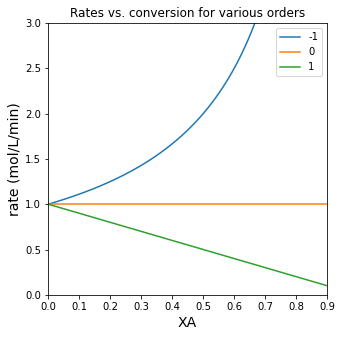

In [8]:
XAset = np.linspace(0, 0.9, 100)

plt.figure(1, figsize = (5,5)) 

for alpha in range(-1, 2, 1):
    plt.plot(XAset, r(XAset, alpha), label = str(alpha))  

plt.title('Rates vs. conversion for various orders')
plt.ylabel('rate (mol/L/min)', fontsize = 14)
plt.xlabel('XA', fontsize = 14)
plt.xlim(0,0.9)
plt.ylim(0,3)
plt.legend()
plt.show(1)

Although we only show a few reaction orders in the plot, the trends are completely general. Basically:

1. For $\alpha > 0$, the rate of reaction decreases with increasing fractional conversion of A (as CA decreases)
2. For $\alpha = 0$, the rate of reaction is independent of fractional conversion of A
3. For $\alpha < 0$, the rate of reaction increases with increasing fractional conversion of A (as CA decreases)

### The Levenspiel Plot

Now we'll take a look at the balances for the CSTR and the PFR:

$$V_\textrm{CSTR} = \frac{F_{A,f}}{r \, (X_A)}X_A$$

and

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f}}{r \, (X_A)}dX_A$$

We see that the size of the reactor scales with the ratio of the feed rate of A and the rate of reaction.  Above, we created functions that describe the rate of reaction for various reaction orders. We'll do something similar here and call it a Levenspiel plot.  The quantity of interest for us is the ratio, $F_{A,f}/r \, (X_A)$, so we'll write that in a function and then plot it vs. fractional conversion.

Specifically:

$$\frac{F_{A,f}}{r \, (X_A)} = \frac{F_{A,f}}{k{C_{A,f}}^\alpha \, (1 - X_A)^\alpha}$$

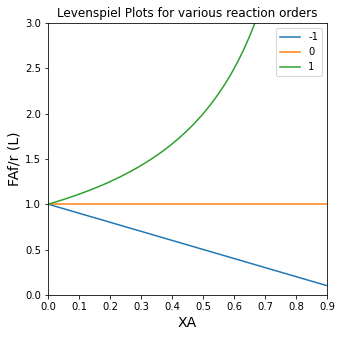

In [9]:
def LEV(XA, alpha):
    k   = 1 #units to vary with reaction order so that r = mol/L/min
    CAf = 1 #mol/L
    FAf = 1 #mol/min
    CA  = CAf*(1 - XA)
    r   = k*CA**alpha
    return FAf/r

XAset = np.linspace(0, 0.9, 100)

plt.figure(1, figsize = (5,5))
for alpha in range(-1, 2, 1):
    plt.plot(XAset, LEV(XAset, alpha), label = str(alpha))

plt.title('Levenspiel Plots for various reaction orders')
plt.ylabel('FAf/r (L)', fontsize = 14)
plt.xlabel('XA', fontsize = 14)
plt.xlim(0,0.9)
plt.ylim(0,3)
plt.legend()
plt.show(1)

Remember: the figure above is basically showing you how inverse rate changes as a function of fractional conversion.  For positive order kinetics, inverse rate gets bigger as a function of conversion.  For negative order kinetics, inverse rate gets smaller as a function of conversion.  For zero order kinetics, inverse rate is constant as a function of conversion.

To use the plots and to start understanding the trends, we'll focus on the first order case.  Before we do, let's recall some results for CSTR and PFR volumes required to achieve specific conversions for the first order case.  I'll ask for volumes required for conversions of 0.2, 0.5, and 0.9.

In [10]:
XAtest = [0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9]
VCtest = [VCSTR(val, 1) for val in XAtest] #I'm using a comprehension here; shorthand for loop
VPtest = [VPFR(val, 1) for val in XAtest]  #another list comprehension

for XA, VC, VP in zip(XAtest, VCtest, VPtest):  #zip is handy; it let's you iterate over values in multiple sets.
    if XA == 0.05:
        print('For a first order reaction with the specified parameters...')
    print(f'To achieve a conversion of {XA:3.2f}, the CSTR volume is {VC:3.3f}L and the PFR volume is {VP:3.3f}L')

For a first order reaction with the specified parameters...
To achieve a conversion of 0.05, the CSTR volume is 0.053L and the PFR volume is 0.051L
To achieve a conversion of 0.10, the CSTR volume is 0.111L and the PFR volume is 0.105L
To achieve a conversion of 0.20, the CSTR volume is 0.250L and the PFR volume is 0.223L
To achieve a conversion of 0.30, the CSTR volume is 0.429L and the PFR volume is 0.357L
To achieve a conversion of 0.50, the CSTR volume is 1.000L and the PFR volume is 0.693L
To achieve a conversion of 0.75, the CSTR volume is 3.000L and the PFR volume is 1.386L
To achieve a conversion of 0.90, the CSTR volume is 9.000L and the PFR volume is 2.303L


Now that we have specific volumes in mind for these various cases, we can proceed with the Levenspiel Plot analysis.  We'll go back again to the balances on the CSTR and PFR that we have solved for volume:

Now we'll take a look at the balances for the CSTR and the PFR.  We will look at the CSTR first.

$$V_\textrm{CSTR} = \frac{F_{A,f}}{r \, (X_A)}X_A$$

Notice:  this is actually the product of our "LEV" function, $F_{A,f}/r \, (X_A)$, and the fractional conversion achieved in that reactor.  Since we assume a CSTR is perfectly mixed, the relevant reaction rate is specified at the exit composition (exit conversion).  This is to say that the entire volume of a CSTR is at an identical conversion value because it is perfectly mixed.  That means the rate of reaction in a CSTR is uniform throughout, and that the rate of reaction is **calculated at the exit conditions of the CSTR**.  In a graphical context, if we plot our "LEV" function against fractional conversion, then the volume of a CSTR is given by the product of the "LEV" function value at a specific conversion (i.e., the "y" axis on our plot) and the value of fractional conversion at the reactor exit (i.e., the "x" axis on our plot).  It looks like a rectangle defined by the exit conditions on the Levenspiel plot.

In the PFR, we see that the right hand side involves the product of our "LEV" function, $F_{A,f}/r \, (X_A)$ and a differential change in fractional conversion.  To determine the PFR volume, we have to evaluate the integral on the right hand side.  Specifically, we are integrating our "LEV" function, $F_{A,f}/r \, (X_A)$, as a function of fractional conversion. This allows us to account for the way a PFR operates, which is to incrementally increase conversion from inlet to exit through a series of axial slices.  In a graphical context, the volume of the PFR represents the area under the curve in a Levenspiel plot.

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f}}{r \, (X_A)}dX_A$$

So, graphing our "LEV" function vs. fractional conversion for a first order reaction gives us our "Levenspiel Plot" for this case.

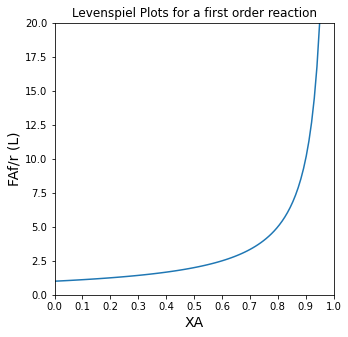

In [11]:
XAset = np.linspace(0, 0.95, 100)
plt.figure(1, figsize = (5,5))
plt.plot(XAset, LEV(XAset, 1))
plt.title('Levenspiel Plots for a first order reaction')
plt.ylabel('FAf/r (L)', fontsize = 14)
plt.xlabel('XA', fontsize = 14)
plt.xlim(0,1)
plt.ylim(0,20)
plt.xticks(np.linspace(0, 1, 11))
plt.show(1)

We'll add a bit of detail to that plot.  Specifically, we'll add a vertical line at XA = 0.9, and we'll add a horizontal line at the corresponding value of FAf/r.

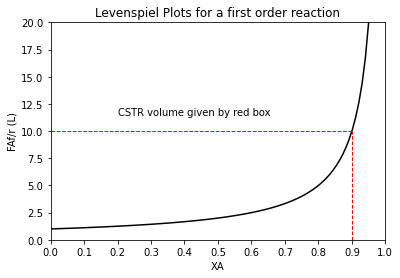

In [12]:
XAset = np.linspace(0, 0.95, 100)
plt.plot(XAset, LEV(XAset, 1), color = 'black')
plt.vlines(0.9, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, 1), 0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red box', (0.2, 11.5))
plt.title('Levenspiel Plots for a first order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0,20)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

The volume of the CSTR is given by the product of FAf/r and XA at the exit.  Here, we see those numbers are 10L and 0.9.  Multiply them together, and we get the CSTR volume is 9.0L just as we did in the analytical solution.

In contrast, if we wanted to get the PFR volume, we'd need to take the integral of FAf/r from XA = 0 to XA = 0.9, i.e., we would have to find the area under the curve shown in the figure above.  We'll add that illustration to show the PFR volume on the Levenspiel plot.

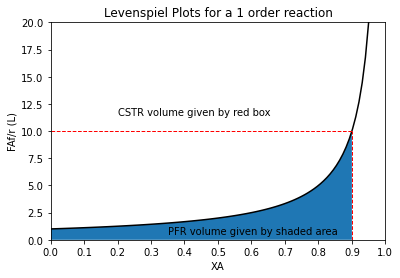

In [13]:
order = 1
XAset = np.linspace(0, 0.95, 100)
XAPFR = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAPFR, LEV(XAPFR, order))
plt.vlines(0.9, 0, LEV(0.9, order), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red box', (0.2, 11.5))
plt.annotate('PFR volume given by shaded area', (0.35, 0.5))
plt.title(f'Levenspiel Plots for a {order} order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

There are a lot of ways to do the integral, but since we have a function for the Levenspiel plot, using quadrature to integrate it is straightforward.  See below --- we find that it is 2.3 liters just like in the solution above:

In [14]:
integrand      = lambda x: LEV(x, 1)
VPFR_quad, err = quadrature(integrand, 0, 0.9)
VPFR_quad

2.3025850836843293

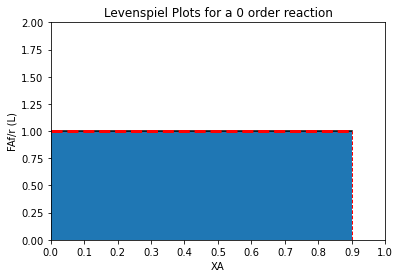

In [15]:
order = 0
XAset = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAset, LEV(XAset, order))
plt.vlines(0.9, 0, LEV(0.9, order), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 3)
#plt.annotate('CSTR volume given by red box', (0.2, 11.5))
#plt.annotate('PFR volume given by shaded area', (0.35, 0.5))
plt.title(f'Levenspiel Plots for a {order} order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, 2*ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

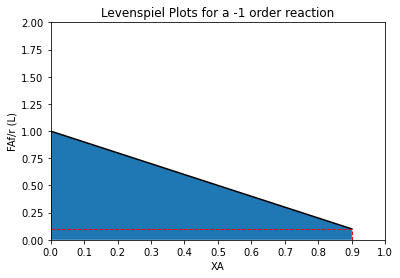

In [16]:
order = -1
XAset = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAset, LEV(XAset, order))
plt.vlines(0.9, 0, LEV(0.9, order), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
#plt.annotate('CSTR volume given by red box', (0.2, 11.5))
#plt.annotate('PFR volume given by shaded area', (0.35, 0.5))
plt.title(f'Levenspiel Plots for a {order} order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, 2*ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

The **reason** that we observe these differences has to do with the fundamental difference in the way that PFRs and CSTRs and CSTRs operate. With a PFR, the conversion (and concentration) change gradually as we go from the inlet of the reactor to the exit of the reactor.  The PFR begins operation at a very high concentration of A at the inlet, and it gradually approaches a low concentration of A at the exit.  So the rate of reaction incrementally changes down the length of the PFR.  

For a positive order reaction, the rate *decreases* down the length of the PFR.  For a zero order reaction, the rate is *constant* down the length of the PFR. For a negative order reaction, the rate *increases* down the length of the PFR.  In all cases, we have to average these effects by integrating with respect to the differential changes in volume that occur as we move from one axial slice to the next down the length of the PFR.

A CSTR is the exact opposite.  As soon as the feed enters the CSTR, it is instantly mixed, and the inside of the CSTR all exists as the same conditions as at the CSTR exit.  So whatever the exit concentration is, that is the concentration inside the CSTR. As a result, the CSTR always operates at the lowest possible value of concentration for the specified level of conversion.  In other words, it operates entirely at the conversion we have specified for the system.  For a positive order reaction, this means that the rate is at the minimum possible value (lowest CA).  For a zero order reaction, the rate is independent of conversion/concentration, so operating at a conversion of 90% gives you the same rate you'd see at a conversion of 0%.  For negative order reaction, rate increases with conversion, so the CSTR operates at minimum concentration of A, which gives a maximum reaction rate!

For a positive order reaction, on average, the PFR will always have the higher rate across the reactor volume--it starts at a high rate and finishes at the minimum rate.  The CSTR operates entirely at the minimum rate, so it's average reaction rate is always lower for a positive order reaction.  The converse is true for a negative order reaction--the rate will gradually increase down the length of the PFR, whereas the CSTR operates entirely at the exit conversion and thus the maximum rate.  For a zero order reaction, rate is independent of conversion, and PFRs and CSTRs will have the same average rate.

Since the size of a system is determined by the ratio of the "stuff" that gets converted to the rate at which it gets converted, it is easy to predict PFR and CSTR sizing trends once we grasp the above concepts.  PFRs will always be smaller for positive order reactions because, on average, they have a higher reaction rate than a CSTR achieving the same conversion.  In contrast, for negative order reactions, PFRs will always be larger because, on average, they have a lower reaction rate than a CSTR achieving the same conversion.  For zero order reactions, they will be the exact same size because the rates are equal in the two systems.